<>:92: SyntaxWarning: invalid escape sequence '\D'

<>:165: SyntaxWarning: invalid escape sequence '\D'

<>:92: SyntaxWarning: invalid escape sequence '\D'

<>:165: SyntaxWarning: invalid escape sequence '\D'

/tmp/ipykernel_1181179/4026943383.py:92: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(times, sun_mag_diff, color='gold', lw=4, label='Sun $\Delta V$', alpha=0.7, zorder=1)

/tmp/ipykernel_1181179/4026943383.py:165: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel(r'Kick Magnitude Change $\Delta |V_{kick}|$ (km/s)', fontsize=12)

正在分析 18 颗脉冲星...
脉冲星: J1041-1942   | 特征年龄:  23.30 Myr | 初始 Kick 速度:  429.36 km/s
脉冲星: J1115+5030   | 特征年龄:  10.50 Myr | 初始 Kick 速度:  412.60 km/s
脉冲星: J2326+6113   | 特征年龄:  10.50 Myr | 初始 Kick 速度:  616.81 km/s
脉冲星: J1321+8323   | 特征年龄:  18.00 Myr | 初始 Kick 速度:  896.15 km/s
脉冲星: J0152-1637   | 特征年龄:  10.10 Myr | 初始 Kick 速度:  301.31 km/s
脉冲星: J1543-0620   | 特征年龄:  12.90 Myr | 初始 Kick 速度:  364.45 km/s
脉冲星: J1840+5640   | 特征年龄:  17.50 Myr 

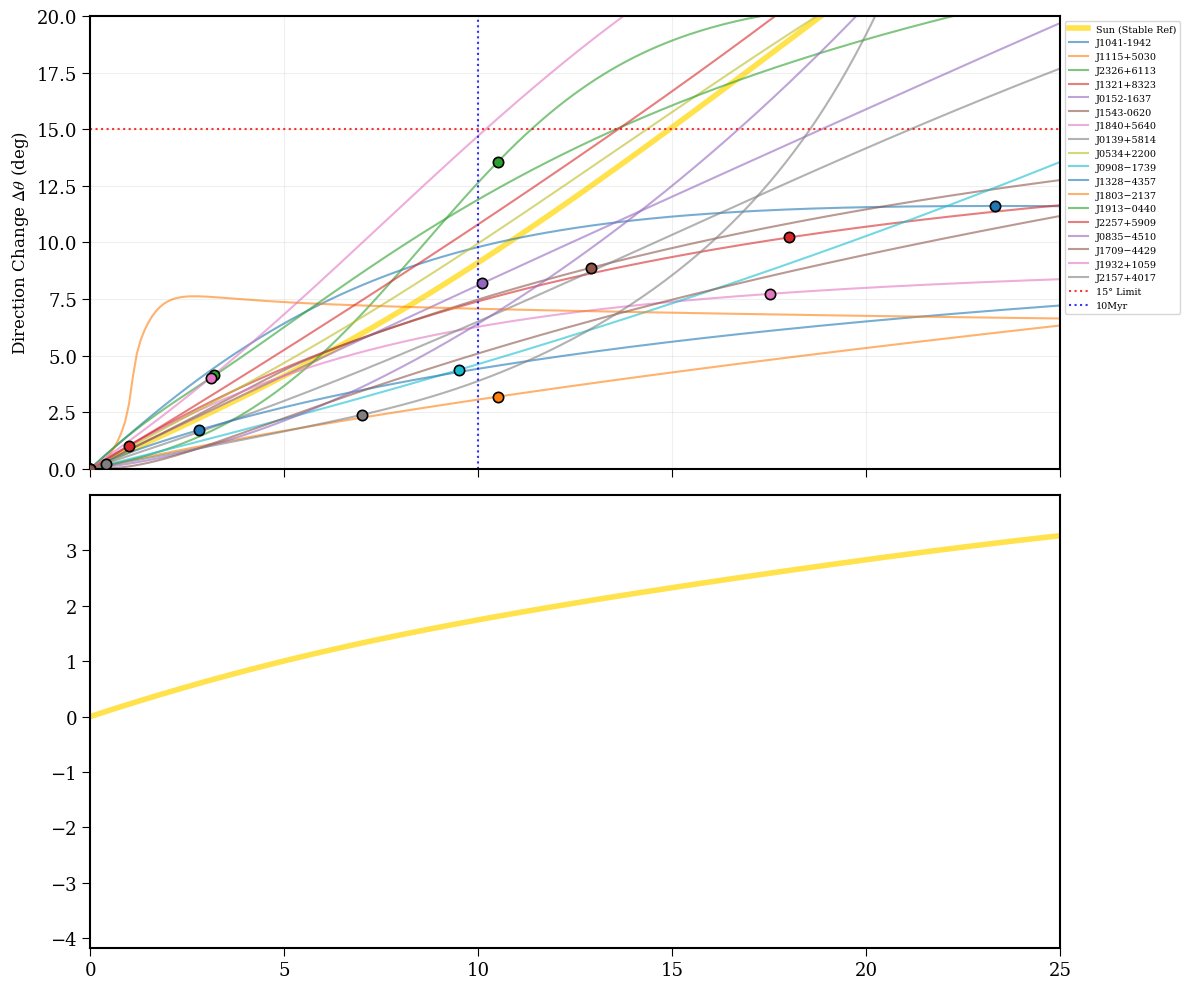

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})
# ==========================================
# 1. 物理环境配置与核心常数
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014

def get_angle(v1, v2):
    """计算两个向量之间的 3D 夹角（度）"""
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)))

def analyze_kick_stability(orbit_obj, times_myr):
    """
    核心动力学计算函数：
    在回溯过程中，每一时刻都计算相对于当地 LSR 的本动速度（Kick 矢量）
    """
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    ts_galpy = -(times_myr / 1000.0) / time_unit_gyr
    
    # 轨道积分
    orbit_obj.integrate(ts_galpy, POT, method='odeint')
    
    # 提取演化轨迹的物理坐标
    x = orbit_obj.x(ts_galpy, use_physical=True)
    y = orbit_obj.y(ts_galpy, use_physical=True)
    vx = orbit_obj.vx(ts_galpy, use_physical=True)
    vy = orbit_obj.vy(ts_galpy, use_physical=True)
    vz = orbit_obj.vz(ts_galpy, use_physical=True)
    
    drifts, magnitudes = [], []
    vk_ref = None

    for i in range(len(ts_galpy)):
        # 计算当前位置的 LSR 速度
        R_cyl = np.sqrt(x[i]**2 + y[i]**2)
        vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
        
        # Galpy 左手系下的旋转速度矢量
        v_lsr = np.array([-vc_local * (y[i] / R_cyl), vc_local * (x[i] / R_cyl), 0.0])
        v_star = np.array([vx[i], vy[i], vz[i]])
        
        # 计算 Kick 矢量: V_kick = V_star - V_LSR
        v_kick = v_star - v_lsr
        
        if i == 0: vk_ref = v_kick # 以 t=0 时刻作为方向基准
        
        drifts.append(get_angle(v_kick, vk_ref))
        magnitudes.append(np.linalg.norm(v_kick))
        
    return np.array(drifts), np.array(magnitudes)

# ==========================================
# 2. 准备绘图画布与时间轴
# ==========================================
T_MAX = 100  # 总回溯时长 (Myr)
times = np.linspace(0, T_MAX, 1000) # 高密度采样确保打点精准
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 计算并绘制太阳基准线
vc_at_sun = vcirc(POT, 1.0) * VO_KMS 
v_sun_total = vc_at_sun + 12.24
o_sun = Orbit([RO_KPC*u.kpc, -11.1*u.km/u.s, v_sun_total*u.km/u.s, 0.0*u.kpc, 7.25*u.km/u.s, 0.0*u.deg],
              ro=RO_KPC, vo=VO_KMS, radec=False)
sun_ang, sun_mag = analyze_kick_stability(o_sun, times)

# 计算太阳的速度变化量 (相对于 t=0)
sun_mag_diff = sun_mag - sun_mag[0]

ax1.plot(times, sun_ang, color='gold', lw=4, label='Sun (Stable Ref)', alpha=0.7, zorder=1)
ax2.plot(times, sun_mag_diff, color='gold', lw=4, label='Sun $\Delta V$', alpha=0.7, zorder=1)

# ==========================================
# 3. 循环处理 Excel 脉冲星数据
# ==========================================
try:
    # 请根据您的实际路径修改
    df = pd.read_excel('/home/lz/galpy8.xlsx')
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

print(f"正在分析 {len(df)} 颗脉冲星...")

for i, row in df.iterrows():
    try:
        # A. 提取基础参数
        name = row['Name']
        ra, dec, dist = row['RA'], row['DEC'], row['Dist']
        pmra, pmdec = row['pmra'], row['pmdec']
        zeta = row['zeta']
        raw_age = row['age']

        # B. 修正年龄单位
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # C. 计算速度分量
        v_t = 4.74047 * dist * np.sqrt(pmra**2 + pmdec**2)
        tan_val = np.tan(np.radians(zeta))
        v_r = v_t / tan_val if abs(tan_val) > 1e-4 else 0.0
        
        # D. 初始化轨道并运行回溯
        o_psr = Orbit([ra, dec, dist, pmra, pmdec, v_r], radec=True, ro=RO_KPC, vo=VO_KMS)
        ang_trace, mag_trace = analyze_kick_stability(o_psr, times)
        
        # --- 关键：计算模长的变化量 ---
        # 减去初始值 (t=0)，使得起始点都在 0
        mag_diff_trace = mag_trace - mag_trace[0]
        # E. 绘制演化曲线
        line, = ax1.plot(times, ang_trace, lw=1.5, alpha=0.6, label=name)
        color = line.get_color()
        #ax2.plot(times, mag_diff_trace, lw=1.5, alpha=0.6, color=color)

        # F. 【精准打点】
        if psr_age_myr <= T_MAX:
            age_idx = np.argmin(np.abs(times - psr_age_myr))
            # --- 新增：获取并打印回溯到特征年龄时的 Kick 速度 ---
            v_kick_at_birth = mag_trace[age_idx]
            print(f"脉冲星: {name:<12} | 特征年龄: {psr_age_myr:>6.2f} Myr | 初始 Kick 速度: {v_kick_at_birth:>7.2f} km/s")
            # --------------------------------------------------
            # 标注角度漂移点
            ax1.scatter(times[age_idx], ang_trace[age_idx], 
                        color=color, s=55, edgecolors='black', linewidths=1.2, zorder=10)
            # 标注速度改变量点
            #ax2.scatter(times[age_idx], mag_diff_trace[age_idx], 
            #            color=color, s=55, edgecolors='black', linewidths=1.2, zorder=10)
        else:
            print(f"跳过打点: {name} 的年龄超过了图表横轴范围。")
    except Exception as e:
        print(f"处理 {row.get('Name', i)} 时出错: {e}")

# 角度漂移图
ax1.axhline(15, color='red', ls=':', alpha=0.8, label='15° Limit')
ax1.axvline(10, color='blue', ls=':', alpha=0.8, label='10Myr')
ax1.set_ylabel(r'Direction Change $\Delta\theta$ (deg)', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='x-small')
ax1.set_xlim(0,25)
ax1.set_ylim(0,20)
# 速度变化图
'''
ax2.axvline(10, color='blue', ls=':', alpha=0.8, label='30° Limit')
ax2.axhline(0.0, color='black', lw=1, alpha=0.8) # 参考零线
ax2.set_ylabel(r'Kick Magnitude Change $\Delta |V_{kick}|$ (km/s)', fontsize=12)
ax2.set_xlabel('Backtracking Time (Myr)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_xlim(0,100)
ax2.set_ylim(-150, 150)
'''
plt.savefig('kick_stability_analysis.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

正在分析 18 颗脉冲星...
源: J1041-1942   | 年龄: 23.30 Myr | 偏转: 11.61 deg
源: J1115+5030   | 年龄: 10.50 Myr | 偏转: 3.19 deg
源: J2326+6113   | 年龄: 10.50 Myr | 偏转: 13.55 deg
源: J1321+8323   | 年龄: 18.00 Myr | 偏转: 10.22 deg
源: J0152-1637   | 年龄: 10.10 Myr | 偏转: 8.19 deg
源: J1543-0620   | 年龄: 12.90 Myr | 偏转: 8.88 deg
源: J1840+5640   | 年龄: 17.50 Myr | 偏转: 7.73 deg
源: J0139+5814   | 年龄: 0.40 Myr | 偏转: 0.23 deg
源: J0534+2200   | 年龄: 0.00 Myr | 偏转: 0.00 deg
源: J0908−1739   | 年龄: 9.52 Myr | 偏转: 4.38 deg
源: J1328−4357   | 年龄: 2.80 Myr | 偏转: 1.72 deg
源: J1803−2137   | 年龄: 0.02 Myr | 偏转: 0.01 deg
源: J1913−0440   | 年龄: 3.22 Myr | 偏转: 4.15 deg
源: J2257+5909   | 年龄: 1.01 Myr | 偏转: 1.03 deg
源: J0835−4510   | 年龄: 0.01 Myr | 偏转: 0.00 deg
源: J1709−4429   | 年龄: 0.02 Myr | 偏转: 0.00 deg
源: J1932+1059   | 年龄: 3.10 Myr | 偏转: 4.02 deg
源: J2157+4017   | 年龄: 7.04 Myr | 偏转: 2.40 deg


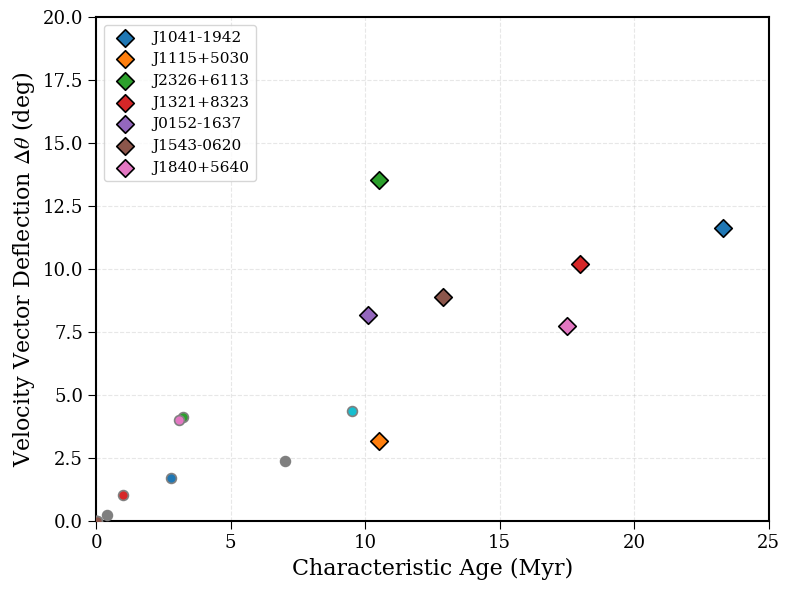

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u

# ==========================================
# 0. 绘图风格设置
# ==========================================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})

# ==========================================
# 1. 物理环境配置
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014

def get_angle(v1, v2):
    """计算两个向量之间的 3D 夹角（度）"""
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)))

def analyze_kick_deflection(orbit_obj, age_myr):
    """
    计算指定年龄处的总偏转角度
    """
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    
    # 我们需要积分两个点：t=0 (现在) 和 t=-age (出生)
    # 稍微多取一点点时间确保插值准确，或者直接积分到目标时间
    ts_galpy = np.linspace(0, -(age_myr / 1000.0) / time_unit_gyr, 100)
    
    # 轨道积分
    orbit_obj.integrate(ts_galpy, POT, method='odeint')
    
    # 提取物理坐标 (t=0 和 t=end)
    # index 0 is present, index -1 is birth
    x = orbit_obj.x(ts_galpy, use_physical=True)
    y = orbit_obj.y(ts_galpy, use_physical=True)
    vx = orbit_obj.vx(ts_galpy, use_physical=True)
    vy = orbit_obj.vy(ts_galpy, use_physical=True)
    vz = orbit_obj.vz(ts_galpy, use_physical=True)
    
    def get_kick_vector(idx):
        R_cyl = np.sqrt(x[idx]**2 + y[idx]**2)
        vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
        # LSR 速度
        v_lsr = np.array([-vc_local * (y[idx] / R_cyl), vc_local * (x[idx] / R_cyl), 0.0])
        v_star = np.array([vx[idx], vy[idx], vz[idx]])
        return v_star - v_lsr

    v_kick_now = get_kick_vector(0)   # t=0
    v_kick_birth = get_kick_vector(-1) # t=age
    
    # 计算相对于 t=0 时刻 Kick 方向的偏转
    deflection = get_angle(v_kick_birth, v_kick_now)
    return deflection

# ==========================================
# 2. 准备绘图画布
# ==========================================
fig, ax = plt.subplots(figsize=(8, 6))

# ==========================================
# 3. 处理数据
# ==========================================
try:
    # 请确认文件路径
    df = pd.read_excel('/home/lz/galpy8.xlsx')
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

print(f"正在分析 {len(df)} 颗脉冲星...")

# 定义颜色循环或映射，如果需要区分不同源
colors = plt.cm.tab10(np.linspace(0, 1, 10))
c_idx = 0

for i, row in df.iterrows():
    try:
        # A. 提取参数
        name = row['Name']
        ra, dec, dist = row['RA'], row['DEC'], row['Dist']
        pmra, pmdec = row['pmra'], row['pmdec']
        zeta = row['zeta']
        raw_age = row['age']

        # 修正年龄单位
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # B. 速度分量计算
        v_t = 4.74047 * dist * np.sqrt(pmra**2 + pmdec**2)
        tan_val = np.tan(np.radians(zeta))
        v_r = v_t / tan_val if abs(tan_val) > 1e-4 else 0.0
        
        # C. 轨道初始化
        o_psr = Orbit([ra, dec, dist, pmra, pmdec, v_r], radec=True, ro=RO_KPC, vo=VO_KMS)
        
        # D. 计算特征年龄处的偏转角
        # 注意：这里我们直接计算特征年龄那一点的偏转，不需要画整条线
        deflection = analyze_kick_deflection(o_psr, psr_age_myr)
        
        # E. 决定图例 (Legend)
        # 仅当特征年龄 > 10 Myr 时显示名称，否则不显示
        if psr_age_myr > 10.0:
            label_text = name
            marker_style = 'D' # 菱形突出显示
            size = 80
            edge_c = 'black'
            zorder = 10
            alpha = 1.0
        else:
            label_text = None # 不会出现在图例中
            marker_style = 'o' # 普通圆点
            size = 50
            edge_c = 'gray'
            zorder = 5
            alpha = 0.7

        # F. 绘制点 (X: 年龄, Y: 偏转角)
        ax.scatter(psr_age_myr, deflection, 
                   label=label_text, 
                   marker=marker_style,
                   s=size, 
                   edgecolors=edge_c,
                   linewidths=1.2,
                   zorder=zorder)
        
        print(f"源: {name:<12} | 年龄: {psr_age_myr:.2f} Myr | 偏转: {deflection:.2f} deg")

    except Exception as e:
        print(f"处理 {row.get('Name', i)} 时出错: {e}")

# ==========================================
# 4. 图表美化
# ==========================================

# 辅助线
#ax.axhline(15, color='red', ls='--', lw=1.5, alpha=0.8, label=r'Deflection Limit ($15^\circ$)')
#ax.axvline(10, color='blue', ls=':', lw=1.5, alpha=0.8, label=r'Age Threshold (10 Myr)')

# 坐标轴标签
ax.set_xlabel('Characteristic Age (Myr)', fontsize=16)
ax.set_ylabel(r'Velocity Vector Deflection $\Delta\theta$ (deg)', fontsize=16)

# 范围设置 (根据你的描述，关注10-30Myr区域，但也需要显示年轻的)
ax.set_xlim(0, 25) # 根据实际数据调整上限，比如到35以包含30Myr的源
ax.set_ylim(0, 20) # 根据最大偏转调整

# 图例设置 (只显示 >10Myr 的源 + 辅助线)
# loc='best' 或指定位置，frameon=False 去掉边框更清爽
ax.legend(loc='upper left', fontsize=11, frameon=True, ncol=1)

ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# 保存
plt.savefig('deflection_vs_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
(1.33*0.2)

0.266

<>:92: SyntaxWarning: invalid escape sequence '\D'

<>:165: SyntaxWarning: invalid escape sequence '\D'

<>:92: SyntaxWarning: invalid escape sequence '\D'

<>:165: SyntaxWarning: invalid escape sequence '\D'

/tmp/ipykernel_1181179/4026943383.py:92: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(times, sun_mag_diff, color='gold', lw=4, label='Sun $\Delta V$', alpha=0.7, zorder=1)

/tmp/ipykernel_1181179/4026943383.py:165: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel(r'Kick Magnitude Change $\Delta |V_{kick}|$ (km/s)', fontsize=12)

正在分析 18 颗脉冲星...
脉冲星: J1041-1942   | 特征年龄:  23.30 Myr | 初始 Kick 速度:  429.36 km/s
脉冲星: J1115+5030   | 特征年龄:  10.50 Myr | 初始 Kick 速度:  412.60 km/s
脉冲星: J2326+6113   | 特征年龄:  10.50 Myr | 初始 Kick 速度:  616.81 km/s
脉冲星: J1321+8323   | 特征年龄:  18.00 Myr | 初始 Kick 速度:  896.15 km/s
脉冲星: J0152-1637   | 特征年龄:  10.10 Myr | 初始 Kick 速度:  301.31 km/s
脉冲星: J1543-0620   | 特征年龄:  12.90 Myr | 初始 Kick 速度:  364.45 km/s
脉冲星: J1840+5640   | 特征年龄:  17.50 Myr 

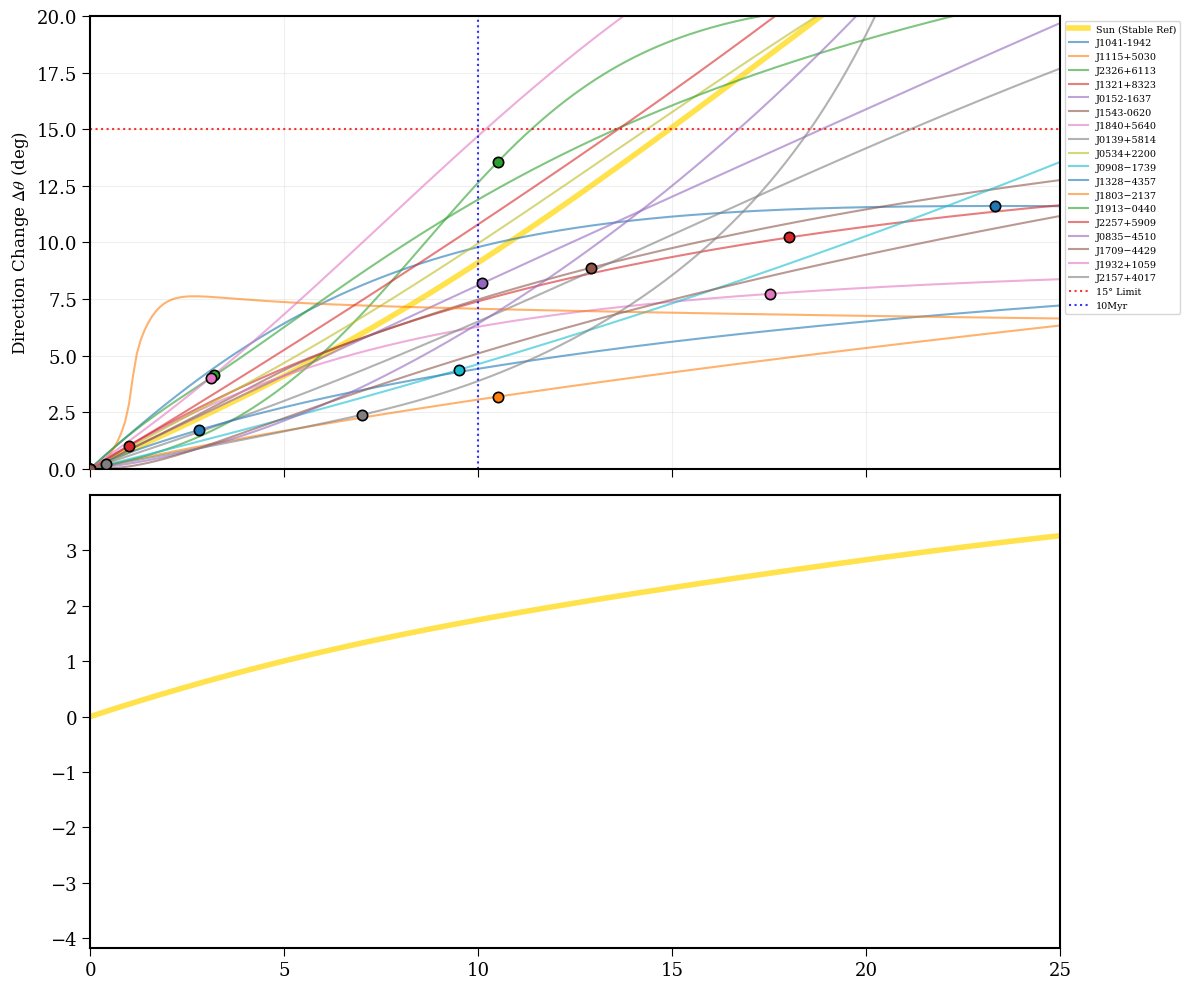

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})
# ==========================================
# 1. 物理环境配置与核心常数
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014

def get_angle(v1, v2):
    """计算两个向量之间的 3D 夹角（度）"""
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)))

def analyze_kick_stability(orbit_obj, times_myr):
    """
    核心动力学计算函数：
    在回溯过程中，每一时刻都计算相对于当地 LSR 的本动速度（Kick 矢量）
    """
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    ts_galpy = -(times_myr / 1000.0) / time_unit_gyr
    
    # 轨道积分
    orbit_obj.integrate(ts_galpy, POT, method='odeint')
    
    # 提取演化轨迹的物理坐标
    x = orbit_obj.x(ts_galpy, use_physical=True)
    y = orbit_obj.y(ts_galpy, use_physical=True)
    vx = orbit_obj.vx(ts_galpy, use_physical=True)
    vy = orbit_obj.vy(ts_galpy, use_physical=True)
    vz = orbit_obj.vz(ts_galpy, use_physical=True)
    
    drifts, magnitudes = [], []
    vk_ref = None

    for i in range(len(ts_galpy)):
        # 计算当前位置的 LSR 速度
        R_cyl = np.sqrt(x[i]**2 + y[i]**2)
        vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
        
        # Galpy 左手系下的旋转速度矢量
        v_lsr = np.array([-vc_local * (y[i] / R_cyl), vc_local * (x[i] / R_cyl), 0.0])
        v_star = np.array([vx[i], vy[i], vz[i]])
        
        # 计算 Kick 矢量: V_kick = V_star - V_LSR
        v_kick = v_star - v_lsr
        
        if i == 0: vk_ref = v_kick # 以 t=0 时刻作为方向基准
        
        drifts.append(get_angle(v_kick, vk_ref))
        magnitudes.append(np.linalg.norm(v_kick))
        
    return np.array(drifts), np.array(magnitudes)

# ==========================================
# 2. 准备绘图画布与时间轴
# ==========================================
T_MAX = 100  # 总回溯时长 (Myr)
times = np.linspace(0, T_MAX, 1000) # 高密度采样确保打点精准
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 计算并绘制太阳基准线
vc_at_sun = vcirc(POT, 1.0) * VO_KMS 
v_sun_total = vc_at_sun + 12.24
o_sun = Orbit([RO_KPC*u.kpc, -11.1*u.km/u.s, v_sun_total*u.km/u.s, 0.0*u.kpc, 7.25*u.km/u.s, 0.0*u.deg],
              ro=RO_KPC, vo=VO_KMS, radec=False)
sun_ang, sun_mag = analyze_kick_stability(o_sun, times)

# 计算太阳的速度变化量 (相对于 t=0)
sun_mag_diff = sun_mag - sun_mag[0]

ax1.plot(times, sun_ang, color='gold', lw=4, label='Sun (Stable Ref)', alpha=0.7, zorder=1)
ax2.plot(times, sun_mag_diff, color='gold', lw=4, label='Sun $\Delta V$', alpha=0.7, zorder=1)

# ==========================================
# 3. 循环处理 Excel 脉冲星数据
# ==========================================
try:
    # 请根据您的实际路径修改
    df = pd.read_excel('/home/lz/galpy8.xlsx')
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

print(f"正在分析 {len(df)} 颗脉冲星...")

for i, row in df.iterrows():
    try:
        # A. 提取基础参数
        name = row['Name']
        ra, dec, dist = row['RA'], row['DEC'], row['Dist']
        pmra, pmdec = row['pmra'], row['pmdec']
        zeta = row['zeta']
        raw_age = row['age']

        # B. 修正年龄单位
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # C. 计算速度分量
        v_t = 4.74047 * dist * np.sqrt(pmra**2 + pmdec**2)
        tan_val = np.tan(np.radians(zeta))
        v_r = v_t / tan_val if abs(tan_val) > 1e-4 else 0.0
        
        # D. 初始化轨道并运行回溯
        o_psr = Orbit([ra, dec, dist, pmra, pmdec, v_r], radec=True, ro=RO_KPC, vo=VO_KMS)
        ang_trace, mag_trace = analyze_kick_stability(o_psr, times)
        
        # --- 关键：计算模长的变化量 ---
        # 减去初始值 (t=0)，使得起始点都在 0
        mag_diff_trace = mag_trace - mag_trace[0]
        # E. 绘制演化曲线
        line, = ax1.plot(times, ang_trace, lw=1.5, alpha=0.6, label=name)
        color = line.get_color()
        #ax2.plot(times, mag_diff_trace, lw=1.5, alpha=0.6, color=color)

        # F. 【精准打点】
        if psr_age_myr <= T_MAX:
            age_idx = np.argmin(np.abs(times - psr_age_myr))
            # --- 新增：获取并打印回溯到特征年龄时的 Kick 速度 ---
            v_kick_at_birth = mag_trace[age_idx]
            print(f"脉冲星: {name:<12} | 特征年龄: {psr_age_myr:>6.2f} Myr | 初始 Kick 速度: {v_kick_at_birth:>7.2f} km/s")
            # --------------------------------------------------
            # 标注角度漂移点
            ax1.scatter(times[age_idx], ang_trace[age_idx], 
                        color=color, s=55, edgecolors='black', linewidths=1.2, zorder=10)
            # 标注速度改变量点
            #ax2.scatter(times[age_idx], mag_diff_trace[age_idx], 
            #            color=color, s=55, edgecolors='black', linewidths=1.2, zorder=10)
        else:
            print(f"跳过打点: {name} 的年龄超过了图表横轴范围。")
    except Exception as e:
        print(f"处理 {row.get('Name', i)} 时出错: {e}")

# 角度漂移图
ax1.axhline(15, color='red', ls=':', alpha=0.8, label='15° Limit')
ax1.axvline(10, color='blue', ls=':', alpha=0.8, label='10Myr')
ax1.set_ylabel(r'Direction Change $\Delta\theta$ (deg)', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='x-small')
ax1.set_xlim(0,25)
ax1.set_ylim(0,20)
# 速度变化图
'''
ax2.axvline(10, color='blue', ls=':', alpha=0.8, label='30° Limit')
ax2.axhline(0.0, color='black', lw=1, alpha=0.8) # 参考零线
ax2.set_ylabel(r'Kick Magnitude Change $\Delta |V_{kick}|$ (km/s)', fontsize=12)
ax2.set_xlabel('Backtracking Time (Myr)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_xlim(0,100)
ax2.set_ylim(-150, 150)
'''
plt.savefig('kick_stability_analysis.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

正在分析 18 颗脉冲星...
源: J1041-1942   | 年龄: 23.30 Myr | 偏转: 11.61 deg
源: J1115+5030   | 年龄: 10.50 Myr | 偏转: 3.19 deg
源: J2326+6113   | 年龄: 10.50 Myr | 偏转: 13.55 deg
源: J1321+8323   | 年龄: 18.00 Myr | 偏转: 10.22 deg
源: J0152-1637   | 年龄: 10.10 Myr | 偏转: 8.19 deg
源: J1543-0620   | 年龄: 12.90 Myr | 偏转: 8.88 deg
源: J1840+5640   | 年龄: 17.50 Myr | 偏转: 7.73 deg
源: J0139+5814   | 年龄: 0.40 Myr | 偏转: 0.23 deg
源: J0534+2200   | 年龄: 0.00 Myr | 偏转: 0.00 deg
源: J0908−1739   | 年龄: 9.52 Myr | 偏转: 4.38 deg
源: J1328−4357   | 年龄: 2.80 Myr | 偏转: 1.72 deg
源: J1913−0440   | 年龄: 3.22 Myr | 偏转: 4.15 deg
源: J2257+5909   | 年龄: 1.01 Myr | 偏转: 1.03 deg
源: J0835−4510   | 年龄: 0.01 Myr | 偏转: 0.00 deg
源: J1709−4429   | 年龄: 0.02 Myr | 偏转: 0.00 deg
源: J1932+1059   | 年龄: 3.10 Myr | 偏转: 4.02 deg
源: J2157+4017   | 年龄: 7.04 Myr | 偏转: 2.40 deg
源: J0538+2817   | 年龄: 0.62 Myr | 偏转: 0.58 deg


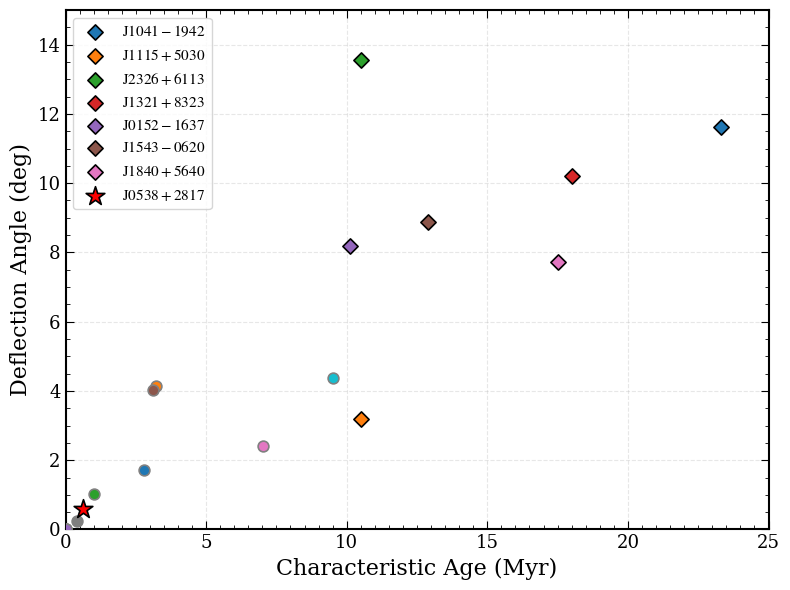

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u
from matplotlib.ticker import MultipleLocator,FuncFormatter
# ==========================================
# 0. 绘图风格设置
# ==========================================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
})

# ==========================================
# 1. 物理环境配置
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014

def get_angle(v1, v2):
    """计算两个向量之间的 3D 夹角（度）"""
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)))

def analyze_kick_deflection(orbit_obj, age_myr):
    """计算指定年龄处的总偏转角度"""
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    ts_galpy = np.linspace(0, -(age_myr / 1000.0) / time_unit_gyr, 100)
    orbit_obj.integrate(ts_galpy, POT, method='odeint')
    
    x = orbit_obj.x(ts_galpy, use_physical=True)
    y = orbit_obj.y(ts_galpy, use_physical=True)
    vx = orbit_obj.vx(ts_galpy, use_physical=True)
    vy = orbit_obj.vy(ts_galpy, use_physical=True)
    vz = orbit_obj.vz(ts_galpy, use_physical=True)
    
    def get_kick_vector(idx):
        R_cyl = np.sqrt(x[idx]**2 + y[idx]**2)
        vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
        v_lsr = np.array([-vc_local * (y[idx] / R_cyl), vc_local * (x[idx] / R_cyl), 0.0])
        v_star = np.array([vx[idx], vy[idx], vz[idx]])
        return v_star - v_lsr

    v_kick_now = get_kick_vector(0)
    v_kick_birth = get_kick_vector(-1)
    return get_angle(v_kick_birth, v_kick_now)

# ==========================================
# 2. 准备绘图画布
# ==========================================
fig, ax = plt.subplots(figsize=(8, 6))

# ==========================================
# 3. 处理数据
# ==========================================
try:
    df = pd.read_excel('/home/lz/work/pulsar_kick_velocity/galpy8.xlsx')
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

print(f"正在分析 {len(df)} 颗脉冲星...")

for i, row in df.iterrows():
    try:
        # A. 提取参数
        name = row['Name'].strip() # 去除可能的空格
        ra, dec, dist = row['RA'], row['DEC'], row['Dist']
        pmra, pmdec = row['pmra'], row['pmdec']
        zeta = row['zeta']
        raw_age = row['age']
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # B. 速度分量计算
        v_t = 4.74047 * dist * np.sqrt(pmra**2 + pmdec**2)
        tan_val = np.tan(np.radians(zeta))
        v_r = v_t / tan_val if abs(tan_val) > 1e-4 else 0.0
        
        # C. 轨道初始化
        o_psr = Orbit([ra, dec, dist, pmra, pmdec, v_r], radec=True, ro=RO_KPC, vo=VO_KMS)
        deflection = analyze_kick_deflection(o_psr, psr_age_myr)
        
        # ==========================================
        # D. 决定标记样式 (Marker Style)
        # ==========================================
        
        # 默认样式 (年轻脉冲星)
        marker_style = 'o'
        size = 60
        edge_c = 'gray'
        face_c = None # 默认颜色循环
        zorder = 5
        alpha = 0.7
        label_text = None

        # 特殊源 J0538+2817 (五角星, 红色)
        if 'J0538+2817' in name: 
            marker_style = '*'  # 五角星
            size = 200          # 更大，显眼
            edge_c = 'black'
            face_c = 'red'      # 填充红色
            zorder = 10         # 最上层
            alpha = 1.0
            label_text = f"$\\mathrm{{{name}}}$"   # 强制显示标签

        # 其他老脉冲星 (>10 Myr) (菱形)
        elif psr_age_myr > 10.0:
            marker_style = 'D'  # 菱形
            size = 60
            edge_c = 'black'
            zorder = 10
            alpha = 1.0
            label_text = f"$\\mathrm{{{name}}}$"   # 显示标签
        
        # E. 绘制点
        # 如果指定了 face_c (如特殊源)，则使用它，否则让 matplotlib 自动分配颜色
        if face_c:
            ax.scatter(psr_age_myr, deflection, 
                       label=label_text, 
                       marker=marker_style,
                       s=size, 
                       edgecolors=edge_c,
                       facecolors=face_c,
                       linewidths=1.2,
                       zorder=zorder)
        else:
            ax.scatter(psr_age_myr, deflection, 
                       label=label_text, 
                       marker=marker_style,
                       s=size, 
                       edgecolors=edge_c,
                       linewidths=1.2,
                       zorder=zorder)
        
        print(f"源: {name:<12} | 年龄: {psr_age_myr:.2f} Myr | 偏转: {deflection:.2f} deg")

    except Exception as e:
        print(f"处理 {row.get('Name', i)} 时出错: {e}")

# ==========================================
# 4. 图表美化
# ==========================================

# 辅助线
#ax.axhline(15, color='red', ls='--', lw=1.5, alpha=0.8, label=r'Deflection Limit ($15^\circ$)')
#ax.axvline(10, color='blue', ls=':', lw=1.5, alpha=0.8, label=r'Age Threshold (10 Myr)')

# 坐标轴标签
ax.set_xlabel('Characteristic Age (Myr)', fontsize=16)
ax.set_ylabel(r'Deflection Angle (deg)', fontsize=16)

# 范围设置
ax.set_xlim(0, 25) 
ax.set_ylim(0, 15) 

# 图例设置 (单列)
# 这里的 handles 可能会乱，如果希望特殊源排在前面，可以手动排序，但默认通常可以接受
ax.legend(loc='upper left', fontsize=11, frameon=True, ncol=1)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tick_params(top='on', right='on', which='both')
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both',which='both',direction='in')
plt.tight_layout()

# 保存
plt.savefig('deflection_vs_age_highlighted.pdf', dpi=300, bbox_inches='tight')
plt.show()